In [7]:
import numpy as np
from scipy import linalg as la 
import numpy.matlib


A1=1 
B1=0.3 
D1=0.5 
E1=0.2 
Q1=1.0 
Qbar1=1.0 
R1=0.5 
Rbar1=0.5 
tr=0 

finalreg=np.zeros((3,5000))
finalvar=np.zeros((3,5000))
for M in ([2,3,4]):
    
    S1=la.solve_discrete_are(A1,B1,Q1,R1)

    #G1=1/(B*S1*B+R)*(B)*S1*A
    #print('G1',G1)

    J_star1 = (1-(1/M)) * np.trace(S1)
    print('J_star1',J_star1)

    #discrete algebraic riccati eq solver for bar part
    S2=la.solve_discrete_are(A1+D1,B1+E1,Q1+Qbar1,R1+Rbar1)
    #G2=1/((B+E)*S2*(B+E)+R+Rbar)*((B+E))*S2*(A+D)
    #print('G2',G2)
    J_star2 = (1/M) * np.trace(S2) #jstar for bar part
    print('J_star2',J_star2)
    print('J_star1 +J_star2',J_star1 +J_star2)


    A=A1*np.eye(M)+(D1/M)*np.ones((M,M))
    B=B1*np.eye(M)+(E1/M)*np.ones((M,M))
    Q=(Q1/M)*np.eye(M)+(1/M**2)*(Qbar1)*np.ones((M,M))
    R=(R1/M)*np.eye(M)+(1/M**2)*(Rbar1)*np.ones((M,M))

    theta_star = np.concatenate((A,B),axis=1);
    #print(np.shape(theta_star))
    #print(theta_star)
    rho = 3



    N = 200                 #no of monte carlo runs
    n = M                   #state dimension
    m = M                   #Action dimension
    horizon = range(0,5000,1)
    print(np.shape(horizon))
    T = (np.size(horizon))
    print(T)
    Regret = np.zeros((N,T))
    print(np.shape(Regret))


    Re = np.zeros((N,1))
    print(np.shape(Re))

    #Discrete Ricatti solver

    S=la.solve_discrete_are(A,B,Q,R)
    #G1=(numpy.linalg.inv(B.T*S*B+R))*(B.T)*S*A
    #print('G1',G1)
    G=np.dot(np.dot(np.dot(numpy.linalg.inv(np.dot(np.dot(B.T,S),B)+R),(B.T)),S),A)
    print('G',G)
    #[S,~,G] = dare(A,B,Q,R);      % discrete algebraic riccati eq solver
    J_star = np.trace(S);

    ##Initialisation of mu1 and sigma1
    #mu1=np.ones((n,n+m))
    mu1=np.zeros((n,n+m))
    print('S',S)
    print('Jstar',J_star)
    print('Jstar-J_total',J_star-(J_star1 +J_star2))
    #print('mu1',mu1)

    #print('mu12',mu1[1])

    sigma1=np.eye(n+m)
    print('sigma1',sigma1)



    samples=np.zeros((N,1))
    for i in range(N):
        print(i)
        j = 0
        s = 0                               #counter to track number of episodes
        x = np.zeros((n,1))                #Initial state
        u = np.zeros((m,1))


        t_last = 0;
        T_last = 0;

        theta_hat = np.array(mu1)      #parameters of initial gaussian prior
        sigma = sigma1

        det_last = 0;

        for t in range(T):
            #print('t',t)
            if( t==0 or (t-t_last >= T_last+1) or (np.linalg.det(sigma) < 0.5*det_last)):
                while 1:
                    #theta = mvnrnd(theta_hat,sigma);
                    theta=[]
                    for l in range(n):
                        #print(np.shape(theta_hat[l]))
                        thom=np.random.multivariate_normal((theta_hat[l].T),sigma)
                        theta.append(thom)
                    #print(np.array(theta))
                    A_hat = np.array(theta)[:,0:n]
                    B_hat = np.array(theta)[:,n:]
                    A1_hat=A_hat[0,0]-A_hat[0,1]
                    B1_hat=B_hat[0,0]-B_hat[0,1]
                    #S = dare(A_hat,B_hat,Q,R);
                    if ((0.985<A1_hat<1.0125) or (0.295<B1_hat<0.315)):
                        S=la.solve_discrete_are(A_hat,B_hat,Q,R)
                        G=np.dot(np.dot(np.dot(numpy.linalg.inv(np.dot(np.dot(B_hat.T,S),B_hat)+R),(B_hat.T)),S),A_hat)
                        break;

                    #if(np.linalg.norm(A-np.dot(B,G))<rho):
                        #break;


                T_last = t-t_last
                t_last = t
                det_last = np.linalg.det(sigma)
                s = s+1

            #Computing control, next state and regret
            u = -np.dot(G,x)
            z = np.append(x,u)
            z = z.reshape(-1,1)
            c = np.dot(np.dot(x.T,Q),x) + np.dot(np.dot(u.T,R),u)
            Re[i] = Re[i] + (c-J_star)  #Regret update

            #x_next = np.dot(theta_star,z) + np.random.randn(n,1)   #next state updation
            x_next = np.dot(A,x)+np.dot(B,u)+np.random.randn(n,1) #next state updation

            #print('theta_hat[1]',theta_hat)
            #Updating the parameters of the posterior distribution
            for k in range(n):
                v=theta_hat[k]
                v=v.reshape(-1,1) #now (6,1)
                #v=v.T ##now back to (1,6)
                v = v + np.dot(np.dot(sigma,z),(x_next[k]-np.dot(v.T,z)))/(1+np.dot(np.dot(z.T,sigma),z))
                theta_hat[k]=v.T
            temp_prod1 = np.dot(sigma,z)
            temp_prod2 = np.dot(z.T,sigma)
            sigma = sigma - np.dot(temp_prod1,temp_prod2)/(1+np.dot(np.dot(z.T,sigma),z))

            x = x_next


            if(t == horizon[j]):
                Regret[i,j] = Re[i]
                j = j+1




        samples[i] = s
    avg_regret = np.mean(Regret,axis=0)


    var_regret = (1/N)*np.var(Regret,axis=0)


    finalreg[tr,:]=(avg_regret)


    finalvar[tr,:]=(var_regret)

    tr=tr+1

J_star1 1.4547360245667467
J_star2 3.999999999999995
J_star1 +J_star2 5.454736024566742
(5000,)
5000
(200, 5000)
(200, 1)
G [[1.57284161 0.42715839]
 [0.42715839 1.57284161]]
S [[2.72736801 1.27263199]
 [1.27263199 2.72736801]]
Jstar 5.454736024566753
Jstar-J_total 1.0658141036401503e-14
sigma1 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
1

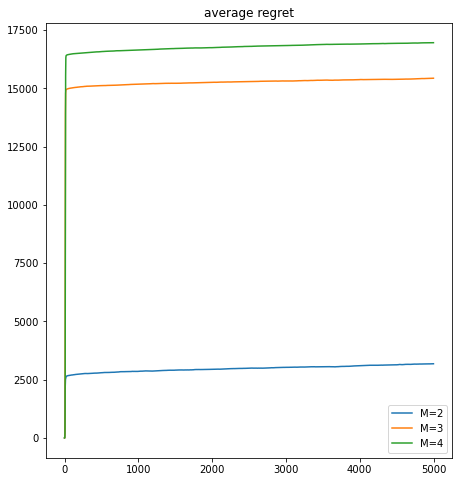

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
#import seaborn as sb
plt.figure(1,figsize=[16,8])
plt.subplot(121)
plt.plot(horizon,finalreg[0,:])
plt.plot(horizon,finalreg[1,:])
plt.plot(horizon,finalreg[2,:])


plt.legend(["M=2","M=3","M=4"])
plt.title('average regret')
plt.show()
plt.savefig('plotNaive_234.png',  bbox_inches='tight')